In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import scipy.special as sp
import itertools

In [117]:
data=pd.read_csv('prostate.data', sep='\t')
data.drop(columns=data.columns[0], inplace=True)

train=pd.Series(data.loc[:,'train'])
data.drop(columns='train', inplace=True)

lpsa=pd.Series(data.loc[:,'lpsa'])
predictors=pd.DataFrame(data.drop(columns='lpsa'))

# Selezionare i dati di training e testing
dataTrain = data.loc[train == 'T'].reset_index(drop=True) #necessario resettare indici
dataTest = data.loc[train == 'F'].reset_index(drop=True)

# Selezionare la serie 'lpsa' dai dati di training e testing
lpsaTrain = pd.Series(dataTrain['lpsa'])
lpsaTest = pd.Series(dataTest['lpsa'])

predictorsTrain=pd.DataFrame(dataTrain.drop(columns='lpsa'))
predictorsTest=pd.DataFrame(dataTest.drop(columns='lpsa'))

scaler = StandardScaler()
predictorsTrain_std = pd.DataFrame(scaler.fit_transform(predictorsTrain), columns=predictorsTrain.columns)
predictorsTest_std = pd.DataFrame(scaler.transform(predictorsTest), columns=predictorsTrain.columns)
#N=len(predictorsTrain_std)
#p=len(predictorsTrain_std.columns)+1
#train_intercept = np.empty(shape=(N, p), dtype=float)
#train_intercept[:, 0] = 1
#train_intercept[:, 1:p] = predictorsTrain_std.values

#ols = sm.OLS(lpsaTrain, train_intercept) #ols come variabili indipendenti accetta solo arraya numpy
#ols_result = ols.fit()
#ols_result.summary2()

In [118]:
data_train=sm.add_constant(predictorsTrain_std)
data_test=sm.add_constant(predictorsTest_std)

est=sm.OLS(lpsaTrain,data_train)
est2=est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     16.47
Date:                Wed, 22 May 2024   Prob (F-statistic):           2.04e-12
Time:                        21:04:25   Log-Likelihood:                -67.505
No. Observations:                  67   AIC:                             153.0
Df Residuals:                      58   BIC:                             172.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4523      0.087     28.182      0.0

In [119]:
# Preparazione spazio dati
varIndices = range(0,8)  # Assumendo 8 variabili da 0 a 7
nTotVars = len(predictorsTrain.columns)

nTotModels=0
for k in range(0, nTotVars+1):
    #print('K=',k)
    nTotModels=nTotModels+sp.binom(nTotVars,k) #coefficiente binomiale
    #print('nTotModels=', nTotModels) #totale modelli generati (256)

nTotModels=int(nTotModels)
# Array per memorizzare i risultati
models_NVars = np.zeros(nTotModels) #numero di variabili per modello
models_AICs = np.zeros(nTotModels) #aic index
models_BICs = np.zeros(nTotModels) #bic index
models_R2s = np.zeros(nTotModels) # rsquare /coefficient determination
models_SSR_train = np.zeros(nTotModels) #residual summare square on trra
models_RMSE_test = np.zeros(nTotModels) #root mean square error on test
models_parIs = [None] * nTotModels  #parameters of the model

In [129]:
data_train

,const,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,1.0,-1.535180,-1.810979,-1.980425,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253
1,1.0,-1.871221,-0.647911,-0.906025,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253
2,1.0,-1.479237,-1.976330,1.242777,-1.003472,-0.537086,-0.843084,0.381857,-0.215549
3,1.0,-2.041272,-0.725785,-0.906025,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253
4,1.0,-0.455756,-0.409561,-0.368824,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253
...,...,...,...,...,...,...,...,...,...
62,1.0,1.567362,1.005663,0.436976,-1.003472,-0.537086,-0.843084,-1.039499,-0.903253
63,1.0,0.988753,0.108784,-0.503124,0.878806,1.861899,-0.843084,0.381857,-0.387475
64,1.0,1.229869,0.529116,0.436976,-1.003472,1.861899,1.104813,0.381857,1.159859
65,1.0,2.033202,0.572482,-2.786226,-1.003472,1.861899,1.714274,0.381857,0.472155


In [131]:
i = 0
for k in range(0, nTotVars + 1):
    selVars= np.zeros(k+1) # indici of selcted var (+1 for intercept)
    print('k=',k)
    for subset in itertools.combinations(varIndices, k):
        print("Subset:", subset)
        selVars[list(range(1,k+1))]=np.asarray(subset)+1
        selVars=selVars.astype(int)
        print(selVars)
        #if k==0:
        #    data_sel=np.ones((data_train.shape[0],1)) #solo intercept
        #else:
        data_sel = data_train.iloc[:, selVars]

        est = sm.OLS(lpsaTrain, data_sel) 
        est2 = est.fit()
        
        # Salvataggio dei risultati
        models_NVars[i] = k
        models_AICs[i] = est2.aic
        models_BICs[i] = est2.bic
        models_R2s[i] = est2.rsquared
        models_SSR_train[i] = est2.ssr
        models_parIs[i] = subset
        
        #test set
        models_RMSE_test[i]=0
        #if k==0:
        #    XTest_sel=np.ones((data_test.shape[0],1)) #solo intercept
        #else:
        XTest_sel = data_test.iloc[:,selVars]

        yTestpred= est2.predict(XTest_sel)
        RMSETest=(((yTestpred-lpsaTest)**2).mean())**0.5
        models_RMSE_test[i]=RMSETest
        
        i+=1
    


k= 0
Subset: ()
[0]
k= 1
Subset: (0,)
[0 1]
Subset: (1,)
[0 2]
Subset: (2,)
[0 3]
Subset: (3,)
[0 4]
Subset: (4,)
[0 5]
Subset: (5,)
[0 6]
Subset: (6,)
[0 7]
Subset: (7,)
[0 8]
k= 2
Subset: (0, 1)
[0 1 2]
Subset: (0, 2)
[0 1 3]
Subset: (0, 3)
[0 1 4]
Subset: (0, 4)
[0 1 5]
Subset: (0, 5)
[0 1 6]
Subset: (0, 6)
[0 1 7]
Subset: (0, 7)
[0 1 8]
Subset: (1, 2)
[0 2 3]
Subset: (1, 3)
[0 2 4]
Subset: (1, 4)
[0 2 5]
Subset: (1, 5)
[0 2 6]
Subset: (1, 6)
[0 2 7]
Subset: (1, 7)
[0 2 8]
Subset: (2, 3)
[0 3 4]
Subset: (2, 4)
[0 3 5]
Subset: (2, 5)
[0 3 6]
Subset: (2, 6)
[0 3 7]
Subset: (2, 7)
[0 3 8]
Subset: (3, 4)
[0 4 5]
Subset: (3, 5)
[0 4 6]
Subset: (3, 6)
[0 4 7]
Subset: (3, 7)
[0 4 8]
Subset: (4, 5)
[0 5 6]
Subset: (4, 6)
[0 5 7]
Subset: (4, 7)
[0 5 8]
Subset: (5, 6)
[0 6 7]
Subset: (5, 7)
[0 6 8]
Subset: (6, 7)
[0 7 8]
k= 3
Subset: (0, 1, 2)
[0 1 2 3]
Subset: (0, 1, 3)
[0 1 2 4]
Subset: (0, 1, 4)
[0 1 2 5]
Subset: (0, 1, 5)
[0 1 2 6]
Subset: (0, 1, 6)
[0 1 2 7]
Subset: (0, 1, 7)
[0 1 2 8]
S

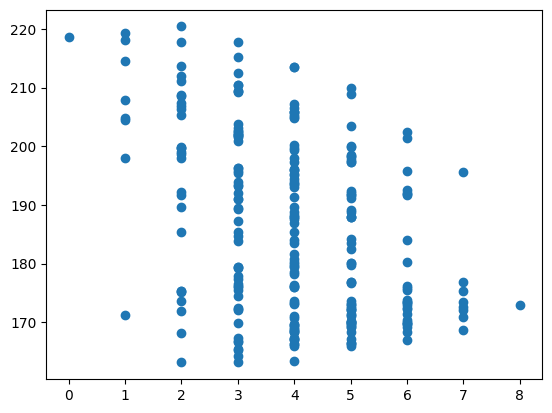

In [139]:
plt.scatter(models_NVars,models_BICs)